z-order reference: https://github.com/Pointcept/PointTransformerV3/blob/main/serialization/z_order.py

In [1]:
%load_ext lab_black
%cd ..

/root/data2/jaehyeok/dev/ddpm/space-filling-pytorch


In [2]:
import torch as th

In [3]:
th.cuda.set_device(9)

In [4]:
# --------------------------------------------------------
# Octree-based Sparse Convolutional Neural Networks
# Copyright (c) 2022 Peng-Shuai Wang <wangps@hotmail.com>
# Licensed under The MIT License [see LICENSE for details]
# Written by Peng-Shuai Wang
# --------------------------------------------------------

import torch
from typing import Optional, Union


class KeyLUT:
    def __init__(self):
        r256 = torch.arange(256, dtype=torch.int64)
        r512 = torch.arange(512, dtype=torch.int64)
        zero = torch.zeros(256, dtype=torch.int64)
        device = torch.device("cpu")

        self._encode = {
            device: (
                self.xyz2key(r256, zero, zero, 8),
                self.xyz2key(zero, r256, zero, 8),
                self.xyz2key(zero, zero, r256, 8),
            )
        }
        self._decode = {device: self.key2xyz(r512, 9)}

    def encode_lut(self, device=torch.device("cpu")):
        if device not in self._encode:
            cpu = torch.device("cpu")
            self._encode[device] = tuple(e.to(device) for e in self._encode[cpu])
        return self._encode[device]

    def decode_lut(self, device=torch.device("cpu")):
        if device not in self._decode:
            cpu = torch.device("cpu")
            self._decode[device] = tuple(e.to(device) for e in self._decode[cpu])
        return self._decode[device]

    def xyz2key(self, x, y, z, depth):
        key = torch.zeros_like(x)
        for i in range(depth):
            mask = 1 << i
            key = key | ((x & mask) << (2 * i + 2)) | ((y & mask) << (2 * i + 1)) | ((z & mask) << (2 * i + 0))
        return key

    def key2xyz(self, key, depth):
        x = torch.zeros_like(key)
        y = torch.zeros_like(key)
        z = torch.zeros_like(key)
        for i in range(depth):
            x = x | ((key & (1 << (3 * i + 2))) >> (2 * i + 2))
            y = y | ((key & (1 << (3 * i + 1))) >> (2 * i + 1))
            z = z | ((key & (1 << (3 * i + 0))) >> (2 * i + 0))
        return x, y, z


_key_lut = KeyLUT()


def xyz2key(
    x: torch.Tensor,
    y: torch.Tensor,
    z: torch.Tensor,
    b: Optional[Union[torch.Tensor, int]] = None,
    depth: int = 16,
):
    r"""Encodes :attr:`x`, :attr:`y`, :attr:`z` coordinates to the shuffled keys
    based on pre-computed look up tables. The speed of this function is much
    faster than the method based on for-loop.

    Args:
      x (torch.Tensor): The x coordinate.
      y (torch.Tensor): The y coordinate.
      z (torch.Tensor): The z coordinate.
      b (torch.Tensor or int): The batch index of the coordinates, and should be
          smaller than 32768. If :attr:`b` is :obj:`torch.Tensor`, the size of
          :attr:`b` must be the same as :attr:`x`, :attr:`y`, and :attr:`z`.
      depth (int): The depth of the shuffled key, and must be smaller than 17 (< 17).
    """

    EX, EY, EZ = _key_lut.encode_lut(x.device)
    x, y, z = x.long(), y.long(), z.long()

    mask = 255 if depth > 8 else (1 << depth) - 1
    key = EX[x & mask] | EY[y & mask] | EZ[z & mask]
    if depth > 8:
        mask = (1 << (depth - 8)) - 1
        key16 = EX[(x >> 8) & mask] | EY[(y >> 8) & mask] | EZ[(z >> 8) & mask]
        key = key16 << 24 | key

    if b is not None:
        b = b.long()
        key = b << 48 | key

    return key


def key2xyz(key: torch.Tensor, depth: int = 16):
    r"""Decodes the shuffled key to :attr:`x`, :attr:`y`, :attr:`z` coordinates
    and the batch index based on pre-computed look up tables.

    Args:
      key (torch.Tensor): The shuffled key.
      depth (int): The depth of the shuffled key, and must be smaller than 17 (< 17).
    """

    DX, DY, DZ = _key_lut.decode_lut(key.device)
    x, y, z = torch.zeros_like(key), torch.zeros_like(key), torch.zeros_like(key)

    b = key >> 48
    key = key & ((1 << 48) - 1)

    n = (depth + 2) // 3
    for i in range(n):
        k = key >> (i * 9) & 511
        x = x | (DX[k] << (i * 3))
        y = y | (DY[k] << (i * 3))
        z = z | (DZ[k] << (i * 3))

    return x, y, z, b

In [5]:
from typing import Tuple

import torch as th
import triton
import triton.language as tl
from torch import Tensor


# @triton.autotune(
#     configs=[
#         triton.Config({"BLOCK_SIZE": 32}),
#         triton.Config({"BLOCK_SIZE": 64}),
#         triton.Config({"BLOCK_SIZE": 128}),
#         triton.Config({"BLOCK_SIZE": 256}),
#         triton.Config({"BLOCK_SIZE": 512}),
#         triton.Config({"BLOCK_SIZE": 1024}),
#     ],
#     key=["BN"],
# )
@triton.jit
def point_to_zorder_3d_depth16_fp32_kernel(
    xyz_ptr,
    distance_ptr,
    B,
    N,
    space_size,
    x_offset,
    y_offset,
    z_offset,
    str_xyz_B,
    str_xyz_N,
    str_xyz_C,
    BLOCK_SIZE: tl.constexpr,
):
    pid_b = tl.program_id(0)
    pid_n = tl.program_id(1)
    offs_n = pid_n * BLOCK_SIZE + tl.arange(0, BLOCK_SIZE)
    mask_n = offs_n < N

    xyz_ptrs = xyz_ptr + pid_b * str_xyz_B + offs_n * str_xyz_N
    fx = tl.load(xyz_ptrs + x_offset * str_xyz_C, mask=mask_n)
    fy = tl.load(xyz_ptrs + y_offset * str_xyz_C, mask=mask_n)
    fz = tl.load(xyz_ptrs + z_offset * str_xyz_C, mask=mask_n)
    x = ((fx + 1) / 2 * space_size).to(tl.int64)
    y = ((fy + 1) / 2 * space_size).to(tl.int64)
    z = ((fz + 1) / 2 * space_size).to(tl.int64)
    x = tl.minimum(tl.maximum(x, 0), space_size - 1)
    y = tl.minimum(tl.maximum(y, 0), space_size - 1)
    z = tl.minimum(tl.maximum(z, 0), space_size - 1)

    # calculate z-order
    ret = 0
    for i in tl.static_range(0, 16):
        q = 1 << i
        ret |= (x & q) << (2 * i + 2)
        ret |= (y & q) << (2 * i + 1)
        ret |= (z & q) << (2 * i + 0)

    # write results
    tl.store(distance_ptr + pid_b * N + offs_n, ret, mask=mask_n)


def point_to_zorder_3d_depth16_fp32(
    xyz: Tensor,
    space_size: int,
    x_offset: int = 0,
    y_offset: int = 1,
    z_offset: int = 2,
):
    assert xyz.ndim == 3, xyz.shape
    assert xyz.size(-1) == 3, xyz.shape
    B, N = xyz.shape[:2]

    distance = xyz.new_empty(B, N, dtype=th.int64)
    grid = lambda meta: (B, triton.cdiv(N, meta["BLOCK_SIZE"]))
    BLOCK_SIZE = max(32, min(4096, triton.next_power_of_2(N)))
    point_to_zorder_3d_depth16_fp32_kernel[grid](
        xyz, distance, B, N, space_size, x_offset, y_offset, z_offset, *xyz.stride(), BLOCK_SIZE=BLOCK_SIZE
    )
    return distance

In [15]:
xyz = th.rand(3, 16, device="cuda") * 2 - 1
grid_size = 2**16

In [10]:
z_order_triton = point_to_zorder_3d_depth16_fp32(xyz[None], grid_size, 0, 1, 2)
# z_order_triton

In [11]:
grid_coord = ((xyz + 1) / 2 * grid_size).long()
x, y, z = grid_coord[:, 0].long(), grid_coord[:, 1].long(), grid_coord[:, 2].long()
z_order_ptv3 = xyz2key(x, y, z)
# z_order_ptv3

In [9]:
th.allclose(z_order_triton, z_order_ptv3)

True

### When not contiguous

In [18]:
xyz = th.rand(3, 16, device="cuda") * 2 - 1
xyz = xyz.transpose(-1, -2)
grid_size = 2**16

In [21]:
xyz.is_contiguous()

False

In [19]:
z_order_triton = point_to_zorder_3d_depth16_fp32(xyz[None], grid_size, 0, 1, 2)
# z_order_triton

In [20]:
grid_coord = ((xyz + 1) / 2 * grid_size).long()
x, y, z = grid_coord[:, 0].long(), grid_coord[:, 1].long(), grid_coord[:, 2].long()
z_order_ptv3 = xyz2key(x, y, z)
# z_order_ptv3

In [22]:
th.allclose(z_order_triton, z_order_ptv3)

True

# Large Scale Test

In [23]:
xyz = th.rand(32768, 3, device="cuda") * 2 - 1
grid_size = 2**16

In [24]:
z_order_triton = point_to_zorder_3d_depth16_fp32(xyz[None], grid_size, 0, 1, 2)
z_order_triton

tensor([[173720110494883, 240318874057055,  85059949043253,  ...,
          36575129060699,  92153334008178, 179067741365104]], device='cuda:9')

In [25]:
grid_coord = ((xyz + 1) / 2 * grid_size).long()
x, y, z = grid_coord[:, 0].long(), grid_coord[:, 1].long(), grid_coord[:, 2].long()
z_order_ptv3 = xyz2key(x, y, z)
z_order_ptv3

tensor([173720110494883, 240318874057055,  85059949043253,  ...,
         36575129060699,  92153334008178, 179067741365104], device='cuda:9')

In [26]:
th.allclose(z_order_triton, z_order_ptv3)

True

# Benchmark

In [29]:
def z_order_ptv3(xyz_batched, grid_size):
    outs = []
    for xyz in xyz_batched:
        xyz = ((xyz + 1) / 2 * grid_size).long()
        outs.append(xyz2key(xyz[:, 0], xyz[:, 1], xyz[:, 2]))
    out = th.stack(outs)
    return out

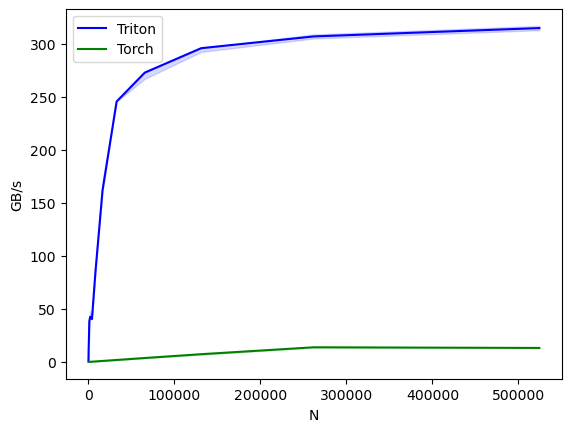

a:
           N      Triton      Torch
0       32.0    1.500000   0.001834
1       64.0    2.400000   0.003633
2      128.0    4.800000   0.007254
3      256.0   12.000000   0.014324
4      512.0   19.200000   0.028760
5     1024.0   38.400001   0.057356
6     2048.0   42.666665   0.115298
7     4096.0   40.421054   0.231186
8     8192.0   85.333330   0.463069
9    16384.0  161.684218   0.928798
10   32768.0  245.760006   1.849488
11   65536.0  273.066663   3.701205
12  131072.0  296.096389   7.299079
13  262144.0  307.200008  13.812561
14  524288.0  315.076934  13.193397


In [30]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=["N"],
        x_vals=[16 * 2**i for i in range(1, 16)],
        x_log=False,
        line_arg="provider",
        line_vals=["triton", "torch"],
        line_names=["Triton", "Torch"],
        styles=[("blue", "-"), ("green", "-")],
        ylabel="GB/s",
        plot_name="a",
        args={"B": 16},
    )
)
def benchmark(B, N, provider):
    x = th.rand(B, N, 3, device="cuda")
    grid_size = 256

    quantiles = [0.5, 0.2, 0.8]
    if provider == "torch":
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: z_order_ptv3(x, grid_size),
            quantiles=quantiles,
        )
    elif provider == "triton":
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: point_to_zorder_3d_depth16_fp32(x, grid_size),
            quantiles=quantiles,
        )

    gbps = lambda ms: (x.nelement() * x.element_size()) * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)


benchmark.run(show_plots=True, print_data=True)